# Notebook for experimenting with different blur detection methods

In [1]:
##Load Images
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kwentar/blur-dataset")

print("Path to dataset files:", path)

c:\Users\marom\Documents\UvA\CV2\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.49G/1.49G [00:48<00:00, 33.3MB/s]

Extracting files...


Path to dataset files: C:\Users\marom\.cache\kagglehub\datasets\kwentar\blur-dataset\versions\2


## Visualize some of the images, motion blur vs original 

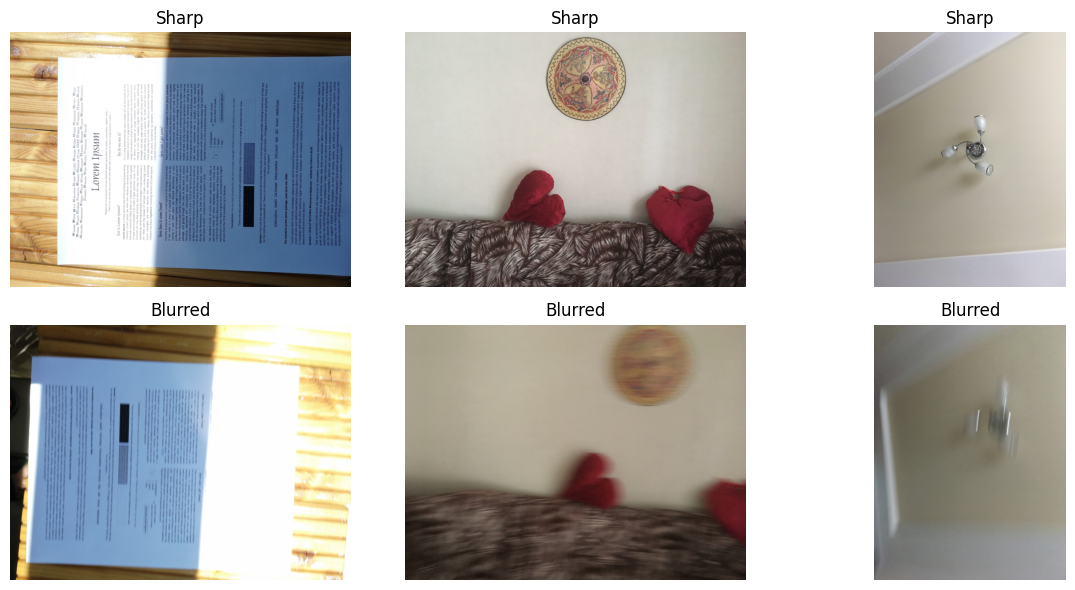

In [15]:
## Visualize some of the images
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define paths
good_frames = os.path.join(path, 'sharp')
bad_frames = os.path.join(path, 'motion_blurred')

good_images = [os.path.join(good_frames, f) for f in os.listdir(good_frames) if f.endswith('.jpg')][:3]
blurred_images = [os.path.join(bad_frames, f) for f in os.listdir(bad_frames) if f.endswith('.jpg')][:3]

# Plot a few images from each category
plt.figure(figsize=(12, 6))

for i in range(3):
    img_good = Image.open(good_images[i])
    img_bad = Image.open(blurred_images[i])

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_good)
    plt.title("Sharp")
    plt.axis('off')

    plt.subplot(2, 3, i + 4)
    plt.imshow(img_bad)
    plt.title("Blurred")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [26]:
#Load all images
good_images = [os.path.join(good_frames, f) for f in os.listdir(good_frames) if f.endswith('.jpg')]
blurred_images = [os.path.join(bad_frames, f) for f in os.listdir(bad_frames) if f.endswith('.jpg')]

### Method 1: Variance of Laplace

In [ ]:
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Function to compute variance of Laplacian (blur detection metric)
def variance_of_laplacian(image_path):
    image = Image.open(image_path)
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return laplacian.var()

# Parameters
threshold = 120 # I only tried 3 values 80, 100 and 120

# Labels: 0 = sharp, 1 = blurry
true_labels = [0] * len(good_images) + [1] * len(blurred_images)
pred_labels = []

# Evaluate images
for img_path in good_images + blurred_images:
    score = variance_of_laplacian(img_path)
    pred = 1 if score < threshold else 0  # 1 = blurry, 0 = sharp
    pred_labels.append(pred)

# Metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")




Accuracy: 0.76
Precision: 0.78
Recall: 0.74
246


### Method 2:  Fast Fourier Transform

In [33]:
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Function to calculate FFT blur score
def fft_blur_score(image_path):
    image = Image.open(image_path)
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # FFT and shift the zero frequency to the center
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  # add 1 to avoid log(0)

    # Define a radius for the high frequency region
    center = tuple(map(lambda x: x // 2, magnitude_spectrum.shape))
    radius = 30  # adjust as needed

    # Create a mask to isolate high-frequency components
    Y, X = np.ogrid[:magnitude_spectrum.shape[0], :magnitude_spectrum.shape[1]]
    distance = np.sqrt((X - center[1]) ** 2 + (Y - center[0]) ** 2)
    high_freq_mask = distance > radius

    # Score: average magnitude of high-frequency components
    high_freq_energy = magnitude_spectrum[high_freq_mask].mean()
    # print(high_freq_energy)
    return high_freq_energy

# Threshold for classifying as blurred
threshold = 150  

# Labels
true_labels = [0] * len(good_images) + [1] * len(blurred_images)
pred_labels = []

# Classify and score
for img_path in good_images + blurred_images:
    score = fft_blur_score(img_path)
    pred = 1 if score < threshold else 0  # 1 = blurry, 0 = sharp
    pred_labels.append(pred)

# Metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print(f"FFT Blur Detection => Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

FFT Blur Detection => Accuracy: 0.58, Precision: 0.95, Recall: 0.17


### Method 3: 